<a href="https://colab.research.google.com/github/akaliutau/ml-for-tackling-climate-change/blob/main/ml_for_climate_change_bubble_challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Final project for the module Machine Learning for Tackling Climate Change

# HaarUNet: A Novel Method to Accurately Simulate Turbulent Flow in Boiling Liquid

**Abstract**

This work proposes a novel approach for simulating complex boiling phenomena. Traditional machine learning architectures (CNNs, GNNs, FNOs, and U-Nets) often struggle to capture the intricate dynamics and sharp gradients inherent in boiling processes, which limits the development of accurate and stable long-term simulations.

Leveraging the comprehensive [BubbleML dataset](https://github.com/HPCForge/BubbleML), this project investigates the potential of relatively unexplored Scientific Machine Learning (SciML) approaches. Specifically, we explore the use of wavelet analysis for feature selection and apply specialized data preprocessing techniques before training the model. We also use various non-conventional approaches to synthesize the final prediction from wavelet coefficients as channel features.

Our results demonstrate that this method improves the prediction of relevant fields (temperature, velocity, and pressure), highlighting the potential of intelligent feature selection for the simulation of turbulent, quasi-chaotic phenomena.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import h5py
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
from tqdm import tqdm
import os

## Versions and Environment

In [ ]:
print("CUDA Version:", torch.version.cuda)
print("CUDA Device Name:", torch.cuda.get_device_name(0))
print("Number of CUDA Devices:", torch.cuda.device_count())


CUDA Version: 12.4
CUDA Device Name: NVIDIA A100-SXM4-40GB
Number of CUDA Devices: 1


## DataSets: EDA and Data Preparations

We are using data from the [BubbleML project](https://arxiv.org/abs/2307.14623):
(https://github.com/HPCForge/BubbleML), a comprehensive collection of high-fidelity simulations that provides accurate ground truth information for various boiling regimes, including nucleate pool boiling, flow boiling, and sub-cooled boiling.

Our experiments are based on dataset #3: Pool Boiling - Subcooled, which consists of 10 time series (short continuous simulations), each with 200 steps and a spatial resolution of 384x384 per frame. The data archive (10.3 GB) is available at
https://bubble-ml-simulations.s3.us-east-2.amazonaws.com/pool-boiling-subcooled-fc72-2d.tar.gz. All the rest datasets are described [here](https://github.com/akaliutau/BubbleML/blob/main/bubbleml_data/README.md)

### First, we download the archive

In [ ]:
#data_source = 'single_bubble'
data_source = 'subcooled'

In [ ]:
!wget https://bubble-ml-simulations.s3.us-east-2.amazonaws.com/pool-boiling-subcooled-fc72-2d.tar.gz

--2025-03-21 19:24:49--  https://bubble-ml-simulations.s3.us-east-2.amazonaws.com/pool-boiling-subcooled-fc72-2d.tar.gz
Resolving bubble-ml-simulations.s3.us-east-2.amazonaws.com (bubble-ml-simulations.s3.us-east-2.amazonaws.com)... 52.219.228.202, 3.5.132.90, 3.5.132.181, ...
Connecting to bubble-ml-simulations.s3.us-east-2.amazonaws.com (bubble-ml-simulations.s3.us-east-2.amazonaws.com)|52.219.228.202|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11108940120 (10G) [binary/octet-stream]
Saving to: ‘pool-boiling-subcooled-fc72-2d.tar.gz’

pool-boiling-subcoo 100%[===================>]  10.35G  14.2MB/s    in 12m 51s 

2025-03-21 19:37:41 (13.7 MB/s) - ‘pool-boiling-subcooled-fc72-2d.tar.gz’ saved [11108940120/11108940120]



In [ ]:
!mkdir -p ./data10
!tar -xzf pool-boiling-subcooled-fc72-2d.tar.gz -C ./data10

In [ ]:
data_path = '/content/data'
data_path10 = '/content/data10/PoolBoiling-SubCooled-FC72-2D'

In [ ]:
subcooled_data = h5py.File(f'{data_path10}/Twall-100.hdf5', 'r')
for idx, key in enumerate(subcooled_data.keys()):
    print(f'{idx + 1}. {key}')

1. dfun
2. int-runtime-params
3. pressure
4. real-runtime-params
5. temperature
6. velx
7. vely
8. x
9. y



Tensor sizes

Each tensor is laid out [T x Y x X] (time, y-direction, x-direction). In this case, there are 200 time steps and the domain resolution is 348x348


In [ ]:
bubble_data = subcooled_data

In [ ]:
tempr = bubble_data['temperature'][:]
[time_res, y_res, x_res] = tempr.shape
print(f'shape: {tempr.shape}')

print(f'# Timesteps: {time_res}')
print(f'Domain resolution: {y_res} x {x_res}')

shape: (201, 384, 384)
# Timesteps: 201
Domain resolution: 384 x 384



### Visualizing different fields in chosen dataset

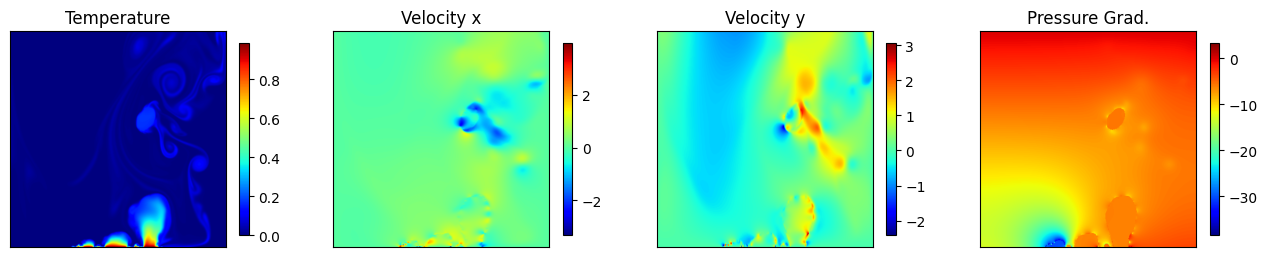

In [ ]:
temp = bubble_data['temperature'][:]
velx = bubble_data['velx'][:]
vely = bubble_data['vely'][:]
pres = bubble_data['pressure'][:]

# compute the velocity magnitude
mag = np.sqrt(velx**2 + vely**2)

# plot the 50-th timestep for each variable
fig, ax = plt.subplots(1, 4, figsize=(16, 5))
fr = 75
data = {
    'Temperature': temp[fr],
    'Velocity x': velx[fr],
    'Velocity y': vely[fr],
    'Pressure Grad.': pres[fr]
}

for idx, (key, im) in enumerate(data.items()):
    im = ax[idx].imshow(im, cmap='jet', origin='lower')
    fig.colorbar(im, ax=ax[idx], shrink=0.5)
    ax[idx].set_title(key)
    ax[idx].set_xticks([])
    ax[idx].set_yticks([])

## Wavelet transformations

We use 2-level [Haar transformation](https://en.wikipedia.org/wiki/Haar_wavelet) on the differences between images in a sequence.

First, we calculate the averages (approximation coefficients) between two neigbour images of the row and the differences (detail coefficients). Then we apply this process recursively on the output of the previous step in that transformation, which results in four Haar coefficients (Figure. 1). We use those coefficients as *features* for our model.

Since we have four initial features (`temperature`, `velx`, `vely`, `pressure`), we get 16 feature channels in the input tensor after transformation.

Note, for convenience we also store the original data and 2 coefficients of the 1-level Haar transformation. As a result, the shape of data for 1 time step after all transformations is (28, 384, 384)

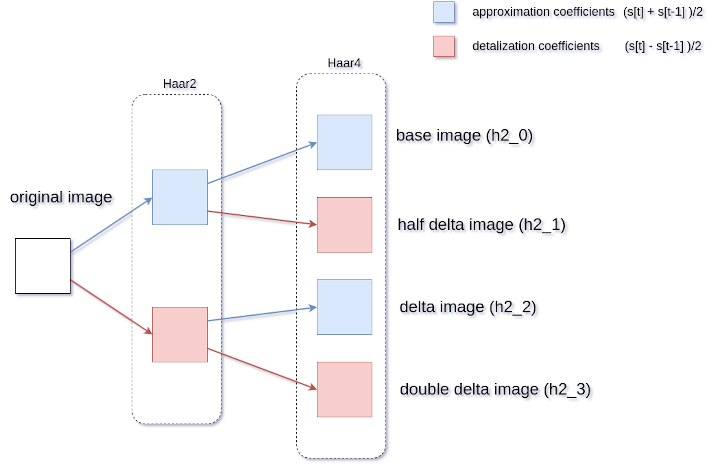

In [ ]:
# POINTER TO THE FOLDER WITH HAAR COEFF (preprocessing stage)
haar_data = "/content/haar_data"
haar_data_test = "/content/haar_data_test"

In [ ]:
def haar_1(data, feature, t):
    """Calculates the Haar2 transform."""
    prev = data[feature][t - 1] if t > 0 else data[feature][t]
    cur = data[feature][t]
    h1_0 = (prev + cur) / 2
    h1_1 = (prev - cur) / 2
    return h1_0, h1_1

def haar_2(data, feature, t):
    """Calculates the Haar4 transform."""
    h2_s, h2_f = haar_1(data, feature, t)
    h2_s_prev, h2_f_prev = haar_1(data, feature, t - 1)
    h2_0 = (h2_s + h2_s_prev) / 2
    h2_1 = (h2_s - h2_s_prev) / 2
    h2_2 = (h2_f + h2_f_prev) / 2
    h2_3 = (h2_f - h2_f_prev) / 2
    return h2_0, h2_1, h2_2, h2_3

def get_coeff(data, feature, t, coeff):
    """Calculates the Haar4 transform."""
    orig = bubble_data[feature][t]
    h1_0, h1_1 = haar_1(bubble_data, feature, t)
    h2_0, h2_1, h2_2, h2_3 = haar_2(bubble_data, feature, t)
    coeff.append(orig) #0
    coeff.append(h1_0) #1
    coeff.append(h1_1) #2
    coeff.append(h2_0) #3
    coeff.append(h2_1) #4
    coeff.append(h2_2) #5
    coeff.append(h2_3) #6

features = ['temperature', 'velx', 'vely', 'pressure']

def generate_haar_data(bubble_data, output_dir):
    """
    Calculates and saves Haar transformed data.

    Args:
        bubble_data: A dictionary containing 'temperature', 'velx', 'vely', 'pressure'
                     as ndarrays of shape (T, X, Y).
        output_dir: Directory to save the transformed data.
    """
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    T, X, Y = bubble_data['temperature'].shape
    print(f'T: {T}, X: {X}, Y: {Y}')

    with tqdm(total=T, desc=f"Processing") as pfilesbar:
      for t in range(T):  # Iterate through all timestamps
          stacked_data = []
          for feature in features:
            get_coeff(bubble_data, feature, t, stacked_data)

          np.save(os.path.join(output_dir, f'haar__{t:03d}.npy'), stacked_data)
          pfilesbar.update(1)


In [ ]:
def inverse_haar_1(h1_0, h1_1):
    """Calculates the inverse Haar2 transform."""
    prev = h1_0 + h1_1
    cur = h1_0 - h1_1
    return prev, cur

def inverse_haar_2(h2_0, h2_1, h2_2, h2_3):
    """Calculates the inverse Haar4 transform."""
    h2_s = h2_0 + h2_1
    h2_s_prev = h2_0 - h2_1
    h2_f = h2_2 + h2_3
    h2_f_prev = h2_2 - h2_3
    return h2_s, h2_f, h2_s_prev, h2_f_prev

def restore_channel(coeff):
    """Restores the original data from Haar4 transformed values."""
    # Inverse of haar_2
    h2_s, h2_f, h2_s_prev, h2_f_prev = inverse_haar_2(coeff[0], coeff[1], coeff[2], coeff[3])
    # Inverse of haar_1 for current time t
    prev_t, cur_t = inverse_haar_1(h2_s, h2_f)
    return cur_t # only need the prediction for moment t

num_orig_features = 4


def restore_data(data):
  """
  Converts a tensor of shape [B, 16, 384, 384] to [B, 4, 384, 384]
  using Inverse Haar Transformation.

  """
  B = data.shape[0]
  output = torch.zeros((B, 4, 384, 384))  # Initialize output tensor
  output = output.type(torch.float32) # convert to float32
  output = output.to(data.device) # move to same device as data

  for b in range(B):
    # Iterate through the channels in groups of 4
    for i in range(num_orig_features):
      h_coeff = data[b, 4*i:4*i+4, :, :] # block of coeff of shape (4, 384, 384)
      restored_channel = restore_channel(h_coeff)
      output[b, i, :, :] = restored_channel

  return output

def restore_data_2(data):
  """
  Converts a tensor of shape [B, 16, 384, 384] to [B, 4, 384, 384]
  using only 2 Haar coefficients:
  * one approximation coefficient (h2_0)
  * one detail coefficient (h2_3)
  Note: this is non-standard technique (heuristic)
  """
  B = data.shape[0]
  output = torch.zeros((B, 4, 384, 384))  # Initialize output tensor
  output = output.type(torch.float32) # convert to float32
  output = output.to(data.device) # move to same device as data

  for b in range(B):
    # Iterate through the channels in groups of 4
    for i in range(num_orig_features):
      h_coeff = data[b, 4*i:4*i+4, :, :] # block of coeff of shape (4, 384, 384)
      output[b, i, :, :] = h_coeff[0,:,:] + h_coeff[2,:,:]

  return output

def restore_data_3(data):
  """
  Converts a tensor of shape [B, 16, 384, 384] to [B, 4, 384, 384]
    using only 2 Haar coefficients:
  * one approximation coefficient (h2_0)
  * one detail coefficient (h2_3)
  Note: this is non-standard technique (heuristic)

  """
  B = data.shape[0]
  output = torch.zeros((B, 4, 384, 384))  # Initialize output tensor
  output = output.type(torch.float32) # convert to float32
  output = output.to(data.device) # move to same device as data

  for b in range(B):
    # Iterate through the channels in groups of 4
    for i in range(num_orig_features):
      h_coeff = data[b, 4*i:4*i+4, :, :] # block of coeff of shape (4, 384, 384)
      output[b, i, :, :] = h_coeff[0,:,:] - h_coeff[2,:,:]

  return output

In [ ]:
input_data = torch.randn(2, 16, 384, 384)
output_data = restore_data(input_data)
print(output_data.shape) # (2, 4, 384, 384)

torch.Size([2, 4, 384, 384])


## Testing Haar Transformations

This cell is to make sure there is no errors in implementation of Haar Transformation

The test methodology:

1. The image at moment t=50 is the target
2. We calculate Haar4 coeff and store them in a tensor of shape (1, 16, 384, 384) (Note, those calculations will involve previous time stamps, so the training has to be done strictly sequentially on each epoch, otherwise we will get data leakage issue. See also: training of RNN and LSTM)
3. Then we restore the target image from coeff

In [ ]:
stacked_data = []
for feature in features:
  get_coeff(bubble_data, feature, 50, stacked_data)
stored_haar_coeff = torch.from_numpy(np.array(stacked_data)).unsqueeze(0)

# Full vector, incl. orig data, 2x Haar2 coeff and 4x Haar4 coeff (total 7 entries) for each of 4 channels
print(stored_haar_coeff.shape)

# orig data in channels: 0, 7, 14, 21
orig_image = stored_haar_coeff[0, [0, 7, 14, 21], :, :].unsqueeze(0)
print(orig_image.shape)

# Haar4 coeff data, 4 per channel
coeff = stored_haar_coeff[0, [3, 4, 5, 6,   10, 11, 12, 13,   17, 18, 19, 20,   24, 25, 26, 27], :, :].unsqueeze(0)
print(coeff.shape)

restored_image = restore_data(coeff)
print(restored_image.shape)
print(torch.mean(restored_image - orig_image).float()) # NOTE: could be non-zero due to float numbers precision!

torch.Size([1, 28, 384, 384])
torch.Size([1, 4, 384, 384])
torch.Size([1, 16, 384, 384])
torch.Size([1, 4, 384, 384])
tensor(-9.9651e-12)


In [ ]:
generate_haar_data(bubble_data, haar_data)

T: 201, X: 384, Y: 384


Processing: 100%|██████████| 201/201 [00:16<00:00, 11.89it/s]


## Preparing test data for a separate roll-out performance test (on the separate time series Twall-103)

We will use this dataset for out-of-the-box prediction tests

In [ ]:
subcooled_data = h5py.File(f'{data_path10}/Twall-103.hdf5', 'r')
for idx, key in enumerate(subcooled_data.keys()):
    print(f'{idx + 1}. {key}')

1. dfun
2. int-runtime-params
3. pressure
4. real-runtime-params
5. temperature
6. velx
7. vely
8. x
9. y


In [ ]:
bubble_data = subcooled_data
tempr = bubble_data['temperature'][:]
[time_res, y_res, x_res] = tempr.shape
print(f'shape: {tempr.shape}')

print(f'# Timesteps: {time_res}')
print(f'Domain resolution: {y_res} x {x_res}')


shape: (201, 384, 384)
# Timesteps: 201
Domain resolution: 384 x 384


In [ ]:
generate_haar_data(bubble_data, output_dir=haar_data_test)

T: 201, X: 384, Y: 384


Processing: 100%|██████████| 201/201 [00:18<00:00, 11.08it/s]


In [ ]:
def calculate_mean_and_plot(data_dir, start_time, end_time):
    """
    Calculates and plots the mean of each Haar component over a time period.

    Args:
        data_dir (str): The directory containing Haar data.
        start_time (int): The start time index (inclusive).
        end_time (int): The end time index (exclusive).
    """
    file_list = sorted([f for f in os.listdir(data_dir) if f.endswith('.npy')])
    file_list = file_list[start_time:end_time]  # Slice the list

    if not file_list:
        raise ValueError("No files found in the specified time range.")

    # Initialize an array to accumulate the data.
    # We sum and then divide at the end to get the mean.
    # This is more numerically stable than updating a running average.
    accumulated_data = np.zeros_like(np.load(os.path.join(data_dir, file_list[0])))

    for filename in file_list:
        filepath = os.path.join(data_dir, filename)
        data = np.load(filepath)
        accumulated_data += data

    mean_values = np.mean(accumulated_data, axis=(1, 2)) / len(file_list) #mean over x,y; div by num timestamps
    num_components = len(mean_values)

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.bar(range(num_components), mean_values)
    ax.set_xlabel('Haar Coeff')
    ax.set_ylabel('Mean Value')
    ax.set_title(f'Means of pre-processed data - 28-feature vector (for the period ({start_time}-{end_time})')
    ax.set_xticks(range(num_components), [f"{features[i//7]} {i}" for i in range(num_components)], rotation=90)
    plt.tight_layout()
    ax.set_yscale('log')
    plt.show()

In [ ]:
def visualize_haar_components(data_dir, component_name, time_step):
    """
    Visualizes the 2nd order Haar components for a specific time step.
    Args:
        data_dir: data directory
        time_step: time step to visualize

    """
    file_name = os.path.join(data_dir, f"haar__{time_step:03d}.npy")
    if not os.path.exists(file_name):
        raise FileNotFoundError(f"File {file_name} not found.")

    data = np.load(file_name)

    # Extract the 2nd order Haar components.  Adjust indices !!
    index = features.index(component_name) * 7
    orig = data[index]
    haar2_coeff = data[index + 3: index + 7]

    fig, axes = plt.subplots(1, 4, figsize=(16, 9))

    for i in range(4):
        im = axes[i].imshow(haar2_coeff[i], cmap=("jet"), origin='lower')
        axes[i].set_title(f"{component_name} h2_{i}")
        fig.colorbar(im, ax=axes[i], shrink=0.35)

    for ax in axes.flatten():
        ax.set_xticks([])
        ax.set_yticks([])

    #plt.title(f"2nd Order Haar Components at Time Step {time_step}", fontsize=16)
    plt.tight_layout()
    plt.show()

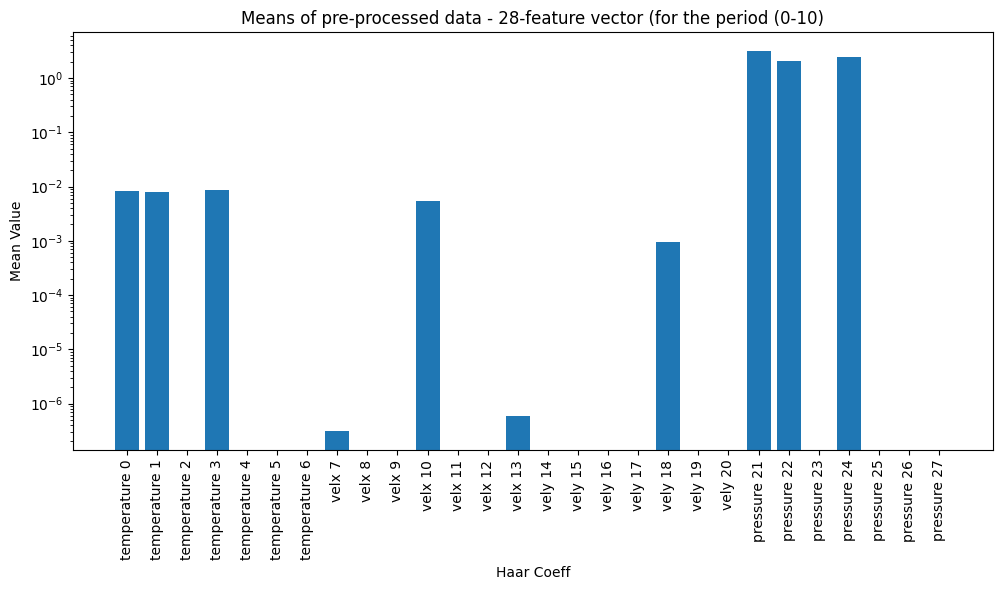

In [ ]:
calculate_mean_and_plot(haar_data, 0, 10)

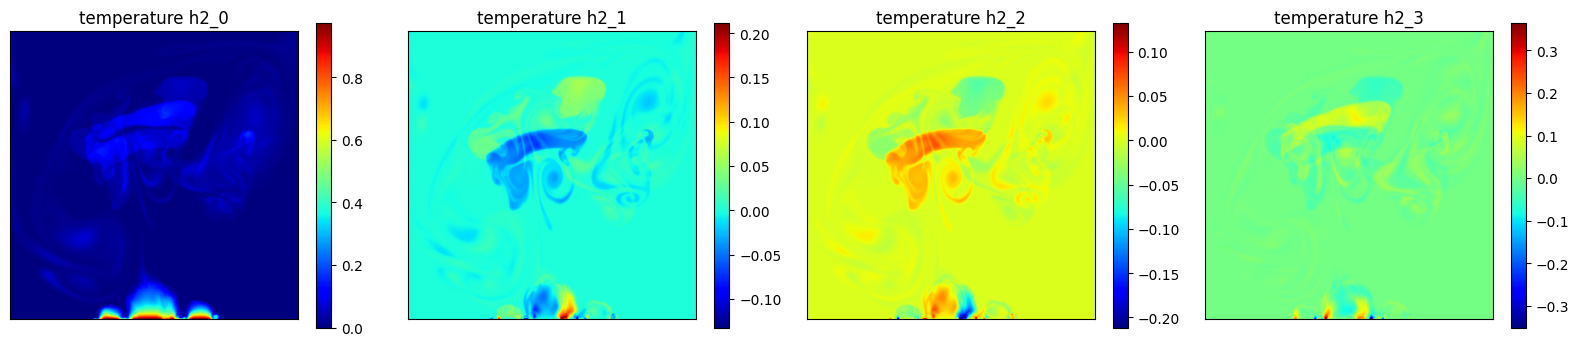

In [ ]:
visualize_haar_components(data_dir=haar_data, component_name='temperature', time_step=50)

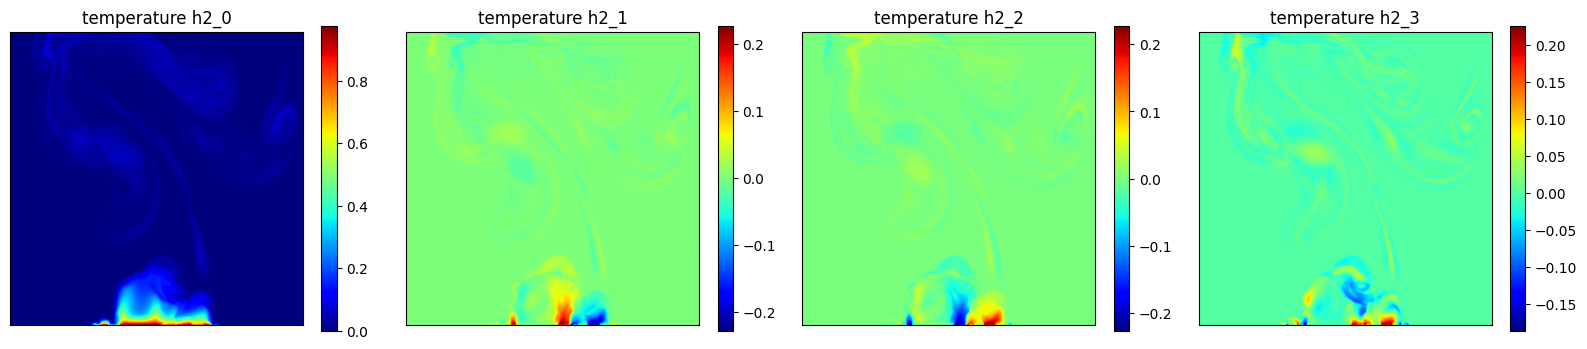

In [ ]:
visualize_haar_components(data_dir=haar_data_test, component_name='temperature', time_step=50)

In [ ]:
file_name = os.path.join(haar_data, f"haar__050.npy")
data = torch.from_numpy(np.load(file_name))
print(f'shape: {data.shape}')
means = torch.mean(data[3:7], dim=(1, 2)).float()
print(means)
stds = torch.std(data[3:7], dim=(1, 2)).float()
print(stds)

shape: torch.Size([28, 384, 384])
tensor([ 2.3744e-02,  1.7304e-04, -1.7304e-04, -8.3164e-05])
tensor([0.0701, 0.0140, 0.0140, 0.0182])


### Animating some fields to understand the dynamics of boiling phenomena (flow, gradients, etc)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import matplotlib.gridspec as gridspec


def animate_fields(fields, filename="animation.gif", interval=500, time_slice=None, cmap='jet'):
    """Animates a 3D tensor (T, H, W) or 4D tensor (T, H, W, C) as a GIF.
    """

    if len(fields.shape) == 3:
        time_steps, height, width = fields.shape
        channels = 1
        fields = fields[:, :, :, None] # Add a channel dimension
    elif len(fields.shape) == 4:
        time_steps, height, width, channels = fields.shape
    else:
        raise ValueError("Data must be a 3D (T, H, W) or 4D (T, H, W, C) numpy array.")

    if time_slice is not None:
        start, stop, step = time_slice
        fields = fields[start:stop:step]
        time_steps = fields.shape[0]  # Update time_steps after slicing

    print(f"time steps={time_steps}")


    fig, ax = plt.subplots()
    ax.axis('off')  # Turn off axis labels and ticks
    frame_0 = fields[0, :, :, 0] if channels == 1 else fields[0, :, :, :]
    # Normalize the data for the first frame to initialize the image

    min_val = np.min(frame_0)
    max_val = np.max(frame_0)
    normalized_frame_0 = (frame_0 - min_val) / (max_val - min_val) if max_val > min_val else np.zeros_like(frame_0)

    # Initialize the image
    im = ax.imshow(normalized_frame_0, cmap=cmap, animated=True, origin='lower')

    # Normalize the data for each field
    # Animation function
    def update(frame):
        if channels == 1:
            # Normalize the data for each frame individually
            min_val = np.min(fields[frame, :, :, 0])
            max_val = np.max(fields[frame, :, :, 0])
            normalized_frame = (fields[frame, :, :, 0] - min_val) / (max_val - min_val) if max_val > min_val else np.zeros_like(fields[frame, :, :, 0]) #Handle edge case of max_val = min_val
            im.set_array(normalized_frame)
        else:
            # Normalize the data for each frame individually for all channels
            min_val = np.min(fields[frame, :, :, :])
            max_val = np.max(fields[frame, :, :, :])
            normalized_frame = (fields[frame, :, :, :] - min_val) / (max_val - min_val) if max_val > min_val else np.zeros_like(fields[frame, :, :, :])  #Handle edge case of max_val = min_val
            im.set_array(normalized_frame)
        return (im,)


    ani = animation.FuncAnimation(fig, update, frames=time_steps, blit=False)
    # Save the animation (requires imagemagick installed)
    ani.save(filename, writer='pillow', fps=10)
    plt.close(fig)  # Close the figure to prevent it from being displayed in the notebook if using one.

    print(f"Animation saved to {filename}")


In [ ]:
# Animate the data and save as a GIF (requires ImageMagick)
# Install ImageMagick:  On Ubuntu/Debian: `sudo apt-get install imagemagick` On MacOS: `brew install imagemagick`
# Make sure the 'convert' command is available in your system's PATH.
print(f'shape: {tempr.shape}')
animate_fields(tempr, filename="animation_tempr.gif")

shape: (201, 384, 384)
time steps=201
Animation saved to animation_tempr.gif


## Some helper visualisation methods

In [ ]:
channel_names = ['Temperature', 'Velocity X', 'Velocity Y', 'Pressure']
def visualize_frames(label, prediction, channel_index=0):
  """
  Visualizes the label, prediction, and delta frames for a specific channel.
  Args:
    label: A numpy array representing the label frame with shape like [1, 4, 288, 96].
    prediction: A numpy array representing the prediction frame with shape like [1, 4, 288, 96].
    channel_index: The index of the channel to visualize
  """

  # Extract the specified channel from the label and prediction
  label_channel = label[0, channel_index, :, :]
  prediction_channel = prediction[0, channel_index, :, :]

  # Calculate the delta (difference)
  delta = prediction_channel - label_channel

  # Create a figure and axes for the visualization
  fig, axes = plt.subplots(1, 3, figsize=(15, 5)) # Adjust figsize for better display

  # Option 1: Using a built-in diverging colormap (e.g., 'coolwarm', 'bwr', 'RdBu')
  colormap = 'coolwarm'

  # Visualize the label
  im1 = axes[0].imshow(label_channel, cmap='jet', origin='lower')
  axes[0].set_title('Ground Truth ({})'.format(channel_names[channel_index]))
  fig.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

  # Visualize the prediction
  im2 = axes[1].imshow(prediction_channel, cmap='jet', origin='lower')
  axes[1].set_title('Prediction ({})'.format(channel_names[channel_index]))
  fig.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

  # Visualize the delta.  Very important:  center colormap on 0
  delta_range = np.max(np.abs(delta))
  im3 = axes[2].imshow(delta, cmap=colormap, vmin=-delta_range, vmax=delta_range, origin='lower') # Diverging colormap
  axes[2].set_title('Delta (Prediction - GT)')
  fig.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)

  # Remove x and y ticks for cleaner visualization
  for ax in axes:
      ax.set_xticks([])
      ax.set_yticks([])

  plt.tight_layout()
  plt.show()

## Data Preparation

In [ ]:
class Normalise:
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, data):
        data = (data - self.mean) / self.std
        return data

class ToFloat32:
    def __init__(self, scale=True):
        return

    def __call__(self, data):
        data = data.float()
        return data


class ToFloatTransform:
    def __init__(self, scale=True):
        return

    def __call__(self, data):
        data = torch.from_numpy(data).float()
        return data


class Compose:
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, data):
        for transform in self.transforms:
            data = transform(data)
        return data

In [ ]:
import h5py
import torch
from torch.utils.data import Dataset, Subset, DataLoader

# Metadata structure:
# name, orig data, (Haar4 coeff)
# offset   0     1     2     3     4     5     6
# data    orig  h1_0  h1_1  h2_0  h2_1  h2_2  h2_3
metadata = [
    ('TEMPERATURE', 0, (3, 7)),
    ('VELX', 7, (10, 14)),
    ('VELY', 14, (17, 21)),
    ('PRESSURE', 21, (24, 28)),
]

# NOTE: temporal wavelet analysis implicitly references previous time steps,
# so training has to be strictly sequential!

class HaarDataset(Dataset):
    def __init__(self, data_dir, transform=None, target_transform=None):
        """
        Initializes the HDF5 dataset.

        Args:
            data_dir (str): Path to the dir with npy files

        """
        self.transform = transform
        self.target_transform = target_transform
        self.data_dir = data_dir

        self.file_list = sorted([f for f in os.listdir(data_dir) if f.endswith('.npy')])
        self.timesteps = len(self.file_list)

        if not self.file_list:
            raise ValueError("No files found in the specified time range.")

        self.num_chunks = self.timesteps // 2  # Number of pairs


    def __len__(self):
        """
        Returns the number of chunks.
        """
        return self.num_chunks

    def _get_input(self, idx):
        r"""
        The input is a 28-feature fector at time=idx
        Specific channels will be extracted in realtime during training/inference
        to form a data for model
        Each feature (orig) is decomposed into wavelet coefficients
         offset   0     1     2     3     4     5     6
         data    orig  h1_0  h1_1  h2_0  h2_1  h2_2  h2_3
        """
        end_idx = idx * 2
        data = np.load(os.path.join(self.data_dir, self.file_list[end_idx]))
        out = torch.from_numpy(data)
        out = out.type(torch.float32) # convert to float32

        if self.transform:
            out = self.transform(out)
        return out

    def _get_label(self, idx):
        r"""
        The output is a 28-feature fector at time=idx + 1
        Specific channels will be extracted in realtime during training/inference
        to form a data for model
        Each feature (orig) is decomposed into wavelet coefficients
         offset   0     1     2     3     4     5     6
         data    orig  h1_0  h1_1  h2_0  h2_1  h2_2  h2_3
        """
        end_idx = idx * 2 + 1
        data = np.load(os.path.join(self.data_dir, self.file_list[end_idx]))
        out = torch.from_numpy(data)
        out = out.type(torch.float32) # convert to float32

        if self.target_transform:
            out = self.target_transform(out)

        return out

    def __getitem__(self, idx):
        r"""
        As input, get temperature, pressure, and velocities at a range of times.
        As the output label, get the temperature, pressure, and velocities at the next timestep
        """
        input = self._get_input(idx)
        label = self._get_label(idx)
        return input, label

In [ ]:
def calculate_channel_mean_std(dataset, batch_size=32):  # Added batch_size
    """
    Calculates the mean and standard deviation for each channel across the entire dataset.
    """

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=0) # num_workers set to zero, good for debugging
    num_channels = dataset[0][0].shape[0]

    channel_sum = torch.zeros(num_channels)
    channel_sum_sq = torch.zeros(num_channels)
    num_pixels_per_channel = 0

    for batch in dataloader:
        in_data, out_data = batch
        #print(in_data.shape)
        #print(out_data.shape)
        channel_sum += torch.sum(in_data, dim=(0, 2, 3))   #sum values in each channel, other dims should be skipped
        channel_sum_sq += torch.sum(in_data ** 2, dim=(0, 2, 3))
        num_pixels_per_channel += in_data.shape[0] * in_data.shape[2] * in_data.shape[3]
        channel_sum += torch.sum(out_data, dim=(0, 2, 3))
        channel_sum_sq += torch.sum(out_data ** 2, dim=(0, 2, 3))
        num_pixels_per_channel += out_data.shape[0] * out_data.shape[2] * out_data.shape[3]

    channel_means = channel_sum / num_pixels_per_channel
    channel_stds = torch.sqrt(channel_sum_sq / num_pixels_per_channel - channel_means ** 2)

    return channel_means.float(), channel_stds.float()


In [ ]:
# Note: init dataset with NULL transformations!
# The goal is to calc the mean and std for each of 28 channels
dataset = HaarDataset(data_dir=haar_data)
dataset[0][0].shape
mean, std = calculate_channel_mean_std(dataset)
print(mean)
print(std)

tensor([ 2.2230e-02,  2.2186e-02, -4.4426e-05,  2.2188e-02, -2.4703e-06,
        -4.3438e-05, -9.8728e-07,  5.8190e-02,  5.7908e-02, -2.8234e-04,
         5.7897e-02,  1.1225e-05, -2.7930e-04, -3.0417e-06, -1.3666e-02,
        -1.3639e-02,  2.7171e-05, -1.3662e-02,  2.3284e-05,  1.5845e-05,
         1.1327e-05,  8.0033e+00,  8.0510e+00,  4.7705e-02,  8.0599e+00,
        -8.8660e-03, -2.9721e-02,  7.7426e-02])
tensor([7.7029e-02, 7.3166e-02, 2.3903e-02, 7.1628e-02, 1.4977e-02, 1.4784e-02,
        1.8760e-02, 3.8890e-01, 3.6506e-01, 1.3195e-01, 3.5582e-01, 8.1625e-02,
        7.9837e-02, 1.0486e-01, 5.3703e-01, 5.2057e-01, 1.2813e-01, 5.1350e-01,
        8.5466e-02, 8.2533e-02, 9.7776e-02, 2.3869e+01, 1.7131e+01, 1.6562e+01,
        1.5137e+01, 8.0324e+00, 8.0071e+00, 1.4387e+01])


## Model structure

U-Net architecture (a CNN type of NN) is widely used for image segmentation and other tasks involving structured output.

The U-Net consists of an encoder (downsampling path) and a decoder (upsampling path) with skip connections.

The DoubleConv module performs two consecutive convolutional layers with batch normalization and ReLU activation.

The skip connections help to preserve fine-grained details and improve the reconstruction quality. The OutConv module is a simple 1x1 convolution used for the final output layer.

Finally, get_latent allows access to the bottleneck layer (we introduced it to analyse the latent space)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):

    def __init__(self, in_channels, out_channels, mid_channels=None, kernel_size=3, dilation=1, reduction=1):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        mid_channels = max(1, in_channels // reduction)
        padding = (kernel_size + (kernel_size - 1) * (dilation - 1) - 1) // 2  # Calculate padding for 'same'

        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=kernel_size, padding=padding, dilation=dilation, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=kernel_size, padding=padding, dilation=dilation, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )


    def forward(self, x):
        x = self.double_conv(x)
        return x


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels),
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()

        self.up = nn.Upsample(scale_factor=2, mode='bicubic', align_corners=True)
        self.conv = DoubleConv(in_channels + in_channels // 2, out_channels, in_channels // 2)


    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)

class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1, padding=0)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, in_channels=4, c_hidden=16, out_channels=4, depth=4):
        super(UNet, self).__init__()
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.depth = depth

        channels=[c_hidden * (2**i) for i in range(depth + 1)]
        # Encoder (Downsampling path)
        self.encoder = nn.ModuleList()
        self.encoder.append(DoubleConv(in_channels, channels[0]))  # Initial conv
        for i in range(depth - 1):
             self.encoder.append(Down(channels[i], channels[i+1]))

        # Bottleneck
        self.bottleneck = DoubleConv(channels[depth - 1], channels[depth])


        # Decoder (Upsampling path)
        self.decoder = nn.ModuleList()
        for i in reversed(range(depth)):
            self.decoder.append(Up(channels[i+1], channels[i]))

        self.out_conv = OutConv(channels[0], out_channels)


    def forward(self, x):
        # Encoder
        x_enc = []
        x_enc.append(self.encoder[0](x))
        for i in range(self.depth - 1):
            x_enc.append(self.encoder[i+1](x_enc[i]))

        # Bottleneck
        x = self.bottleneck(x_enc[-1])
        #print(f'latent space shape: {x.shape}')
        self.latent = x  # Store the latent space representation for extra analysis

        # Decoder with skip connections
        for i in range(self.depth):
           x = self.decoder[i](x, x_enc[self.depth - 1 -i])

        # Output layer
        return self.out_conv(x)

    def get_latent(self):
        return self.latent



In [ ]:
model_test = UNet(in_channels=4, c_hidden=16, out_channels=4, depth=4)
dummy = torch.randn((1, 4, 384, 384))
model_test(dummy).shape

torch.Size([1, 4, 384, 384])

In [ ]:
print(model_test)

UNet(
  (encoder): ModuleList(
    (0): DoubleConv(
      (double_conv): Sequential(
        (0): Conv2d(4, 4, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
        (3): Conv2d(4, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU(inplace=True)
      )
    )
    (1): Down(
      (maxpool_conv): Sequential(
        (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        (1): DoubleConv(
          (double_conv): Sequential(
            (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
            (3): Conv2d(16, 32, kernel_size=(3

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)


cuda


In [ ]:
def train_one_epoch(model, loader, optimizer, criterion, ch):
    model.train()
    avg_loss = 0.0
    for batch in loader:
        in_data, out_data = batch
        in_data, out_data = in_data.to(device), out_data.to(device)
        if ch is not None:
          in_data = torch.index_select(in_data, 1, ch)  # Select channels using index_select
          out_data = torch.index_select(out_data, 1, ch)

        optimizer.zero_grad()
        pred = model(in_data)
        loss = criterion(pred, out_data)
        avg_loss += loss.item()
        loss.backward()
        optimizer.step()
    avg_loss /= len(loader)
    return loss, model


def test_one_epoch(model, loader, criterion, ch):
    model.eval()
    avg_loss = 0.0
    with torch.no_grad():
        for batch in loader:
            in_data, out_data = batch
            in_data, out_data = in_data.to(device), out_data.to(device)
            if ch is not None:
              in_data = torch.index_select(in_data, 1, ch)
              out_data = torch.index_select(out_data, 1, ch)
            pred = model(in_data)
            loss = criterion(pred, out_data)
            avg_loss += loss.item()
    avg_loss /= len(loader)
    return loss


# in train function:
# 1) preserve the training history in the form [(train_lost, test_loss)]
# 2) auto-save the best model (with the lowest test loss)
def train(epoch, model, optimizer, loader_train, loader_test, channels, version=""):
    criterion = torch.nn.MSELoss()
    model = model.to(device)
    if channels is not None:
       channels = torch.tensor(channels, device=device) # move to the device

    history = []
    best_loss = 1e6
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.8)
    with tqdm(total=epoch, desc=f"Training") as pbar:
      for i in range(epoch):
          train_loss, model = train_one_epoch(
              model=model, loader=loader_train, optimizer=optimizer, criterion=criterion, ch=channels)
          test_loss = test_one_epoch(
                  model=model, loader=loader_test, criterion=criterion, ch=channels)
          pbar.set_postfix({"Train Loss" : f"{train_loss}", "Test Loss" : f"{test_loss}"})
          pbar.update(1)
          history.append((train_loss, test_loss))
          scheduler.step()
          if best_loss > test_loss:
              best_loss = test_loss
              model_path = os.path.join(
                  os.path.abspath("."),
                  f"best_model_{version}.pth"
              )
              torch.save(model.state_dict(), model_path)

    return history


In [ ]:
def split_dataset(dataset, train_ratio=0.7, bs=2):
    """
    Splits a Dataset into sequential training and validation subsets.

    Args:
        dataset (Dataset): The Dataset to split.
        train_ratio (float, optional): The ratio of the training set size. Defaults to 0.7.

    Returns:
        tuple: A tuple containing the training and validation Subset objects.
    """
    dataset_size = len(dataset)
    train_size = int(train_ratio * dataset_size)
    val_size = dataset_size - train_size

    train_indices = list(range(train_size))
    val_indices = list(range(train_size, dataset_size))

    train_subset = Subset(dataset, train_indices)
    val_subset = Subset(dataset, val_indices)

    print(f"Total samples: {len(dataset)}")
    print(f"Training samples: {len(train_subset)}")
    print(f"Validation samples: {len(val_subset)}")

    # Access data from the subsets (e.g., first element of training set)
    print("Example training data shape source:", train_subset[0][0].shape)
    print("Example training data shape tgt:", train_subset[0][1].shape)

    # Create data loaders for the subsets
    loader_train = DataLoader(train_subset, batch_size=bs, shuffle=False, num_workers=2)
    loader_val = DataLoader(val_subset, batch_size=bs, shuffle=False, num_workers=2)


    return loader_train, loader_val


In [ ]:
def plot_loss_curves(offset, seq_1, seq_2, model_name):
    label_1, plot_1 = seq_1
    label_2, plot_2 = seq_2

    epochs = range(offset, len(plot_1) + offset) # change the range if needed to zoom in

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, plot_1, 'b-', label=label_1)
    plt.plot(epochs, plot_2, 'r-', label=label_2)

    plt.title(f'Training and Test Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Experiments

## Baseline: simple UNet

Our base model is a simple Unet (depth=4)

In [ ]:
transform = Compose([
    Normalise(mean = mean[:, None, None],  # Reshape to (C, 1, 1),
              std = std[:, None, None]    # Reshape to (C, 1, 1)
    ),
    ToFloat32(),
])

train_dataset = HaarDataset(data_dir=haar_data, transform=transform, target_transform=transform)

idx = 0
data_in, target = train_dataset[idx]

print(data_in.shape)
print(target.shape)

torch.Size([28, 384, 384])
torch.Size([28, 384, 384])


In [ ]:
# Split the dataset into 70% training and 30% validation
train_loader, val_loader = split_dataset(train_dataset, train_ratio=0.7)

Total samples: 100
Training samples: 70
Validation samples: 30
Example training data shape source: torch.Size([28, 384, 384])
Example training data shape tgt: torch.Size([28, 384, 384])


In [ ]:
torch.cuda.empty_cache()

In [ ]:
epoch = 50
lr = 1e-1
# during traning we take only 4 channels with original unprocessed data
base_channels = [0, 7, 14, 21]

model_1 = UNet(in_channels=4, c_hidden=16, out_channels=4, depth=4)

optimizer = torch.optim.AdamW(
    model_1.parameters(),
    lr=lr,
    weight_decay=1e-6,
)
model_name_1 = "unet-baseline"
train_stat_1 = train(epoch=epoch, model=model_1,
                     optimizer=optimizer,
                     loader_train=train_loader, loader_test=val_loader,
                     channels=base_channels,
                     version=model_name_1)

Training: 100%|██████████| 50/50 [03:48<00:00,  4.58s/it, Train Loss=0.42042282223701477, Test Loss=0.6402406692504883]


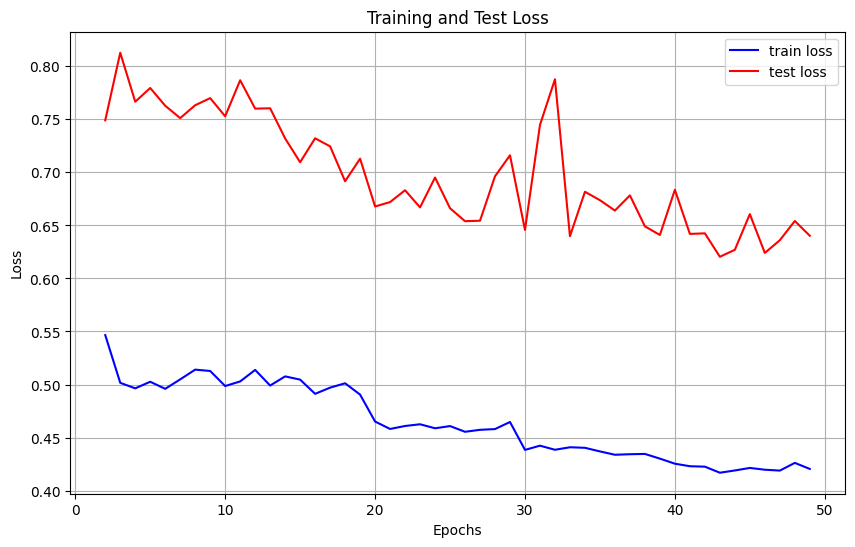

In [ ]:
offset = 2
seq1 = "train loss", [loss[0].detach().cpu().numpy() for loss in train_stat_1][offset:]
seq2 = "test loss", [loss[1].detach().cpu().numpy() for loss in train_stat_1][offset:]

plot_loss_curves(offset, seq1, seq2, model_name_1)

## Our model: HaarUNet

The core of our model is still the same Unet model, with decreased depth (we set depth=3). Training regime is the same as for the baseline model, we do not preform heavy optimisation, since our goal is mostly to investigate how feature selection affects the accuracy of model.

In [ ]:
epoch = 50
lr = 1e-2
bs = 2
haar_channels = [3, 4, 5, 6,   10, 11, 12, 13,   17, 18, 19, 20,   24, 25, 26, 27]
model_2 = UNet(in_channels=16, c_hidden=16, out_channels=16, depth=3)

optimizer = torch.optim.AdamW(
    model_2.parameters(),
    lr=lr,
    weight_decay=1e-6,
)
model_name_2 = "haarunet"
train_stat_2 = train(epoch=epoch, model=model_2,
                     optimizer=optimizer,
                     loader_train=train_loader, loader_test=val_loader,
                     channels=haar_channels, version=model_name_2)

Training: 100%|██████████| 50/50 [03:49<00:00,  4.59s/it, Train Loss=0.14127454161643982, Test Loss=0.6885624527931213]


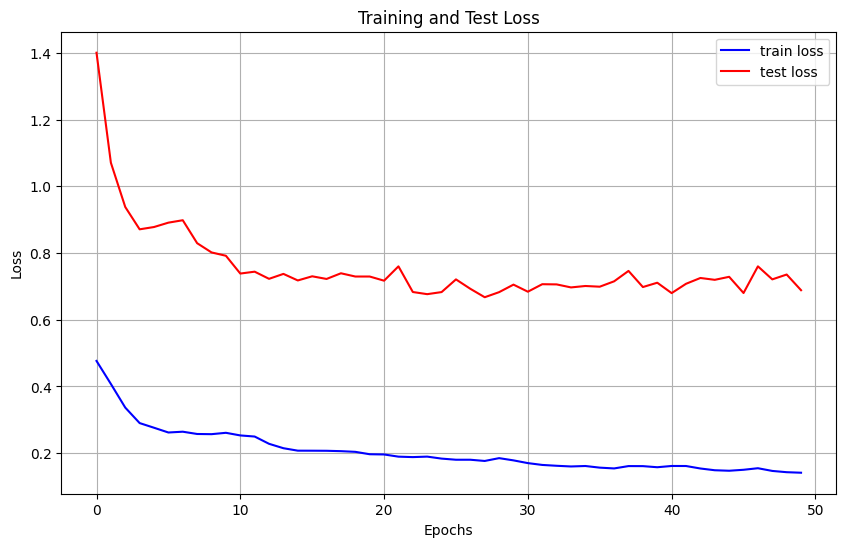

In [ ]:
offset = 0
seq1 = "train loss", [loss[0].detach().cpu().numpy() for loss in train_stat_2][offset:]
seq2 = "test loss", [loss[1].detach().cpu().numpy() for loss in train_stat_2][offset:]

plot_loss_curves(offset, seq1, seq2, model_name_2)
#

## Comparison on train/test data

Our first validation is on step #85 in the dataset which we used for training/testing.

In [ ]:
step = 85
in_b = train_dataset[step][0].unsqueeze(0)
out_b = train_dataset[step][1].unsqueeze(0)
print(in_b.shape)
print(out_b.shape)


torch.Size([1, 28, 384, 384])
torch.Size([1, 28, 384, 384])


In [ ]:
def load_model(model, weight_path, strict=False):
    """
    Loads pre-trained weights into a PyTorch model from a given file path.
    """
    try:
        model.load_state_dict(torch.load(weight_path), strict=strict)
    except RuntimeError:
        state_dict = torch.load(weight_path, map_location=device)
        model.load_state_dict(state_dict, strict=strict)
    return model


def denormalise(data, mean, std):
    return data * std + mean

def calc_norm_error(pred, truth, ord=2):
    pred, truth = [vec.flatten() for vec in [pred, truth]]
    norm = torch.linalg.norm((pred - truth), ord=ord)
    deno = torch.linalg.norm(truth, ord=ord)
    return norm / deno

def calculate_error_and_inference_single_step(data_in, tgt, model, channels, reducer, gt_reducer, mean, std):
    model.to(device)
    model.eval()
    ch = torch.tensor(channels, device=device)
    error = 0.0
    mean_dev = torch.tensor(mean[channels, None, None]).clone().detach().to(device)
    std_dev = torch.tensor(std[channels, None, None]).clone().detach().to(device)
    pred_list = []
    ground_list = []
    with torch.no_grad():
        data_in, target = data_in.to(device), tgt.to(device)
        data_in = torch.index_select(data_in, 1, ch)  # Select channels using index_select
        target = torch.index_select(target, 1, ch)
        pred = model(data_in)
        pred, target = denormalise(pred, mean_dev, std_dev), denormalise(target, mean_dev, std_dev)
        if reducer is not None:
            pred = reducer(pred)
            target = gt_reducer(target)
        pred_list.append(pred.detach().cpu().numpy())
        ground_list.append(target.detach().cpu().numpy())
        error_i = calc_norm_error(pred, target)
        error += error_i.detach()
    return error, pred_list, ground_list

def calculate_error_and_inference(dataloader, model, channels, reducer, gt_reducer, mean, std):
    model = model.to(device)
    model.eval()
    ch = torch.tensor(channels, device=device)
    error = 0.0
    mean_dev = torch.tensor(mean[channels, None, None]).clone().detach().to(device)
    std_dev = torch.tensor(std[channels, None, None]).clone().detach().to(device)
    pred_list = []
    ground_list = []
    error_list = []
    with torch.no_grad():
        for batch in dataloader:
            data_in, target = batch
            data_in, target = data_in, target
            data_in, target = data_in.to(device), target.to(device)
            data_in = torch.index_select(data_in, 1, ch)  # Select channels using index_select
            target = torch.index_select(target, 1, ch)
            pred = model(data_in)
            pred, target = denormalise(pred, mean_dev, std_dev), denormalise(target, mean_dev, std_dev)
            if reducer is not None:
                pred = reducer(pred)
                target = gt_reducer(target)
            pred_list.append(pred.detach().cpu().numpy())
            ground_list.append(target.detach().cpu().numpy())
            error_i = calc_norm_error(pred, target)
            err = error_i.detach().cpu().numpy()
            error_list.append(err)
            error += err
    error /= (len(dataloader) * dataloader.batch_size)
    return error, pred_list, ground_list, error_list

<ipython-input-48-e29cf5dc029b>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean_dev = torch.tensor(mean[channels, None, None]).clone().detach().to(device)
<ipython-input-48-e29cf5dc029b>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std_dev = torch.tensor(std[channels, None, None]).clone().detach().to(device)


tensor(0.6695, device='cuda:0')


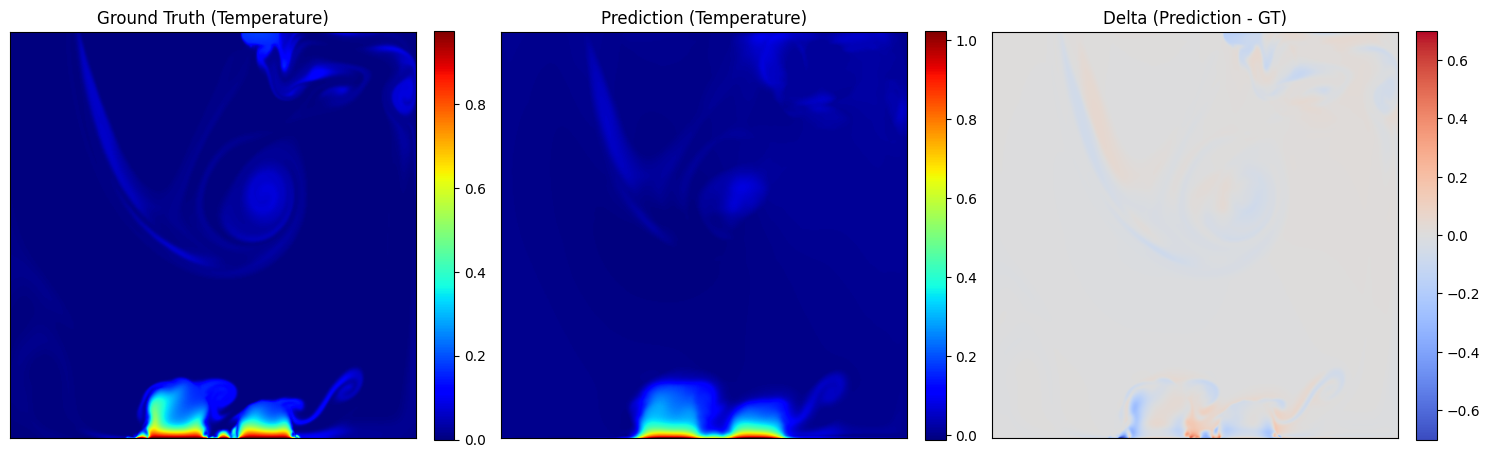

In [ ]:
model = UNet(in_channels=4, c_hidden=16, out_channels=4, depth=4)


model = load_model(model, f"./best_model_unet-baseline.pth")

error, pred, ground = calculate_error_and_inference_single_step(
    in_b, out_b, model,
    channels=base_channels,
    reducer=None,
    gt_reducer=None,
    mean = mean,
    std = std,
)
print(error)
visualize_frames(ground[0], pred[0], channel_index=0)

<ipython-input-48-e29cf5dc029b>:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean_dev = torch.tensor(mean[channels, None, None]).clone().detach().to(device)
<ipython-input-48-e29cf5dc029b>:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std_dev = torch.tensor(std[channels, None, None]).clone().detach().to(device)


tensor(0.3018, device='cuda:0')


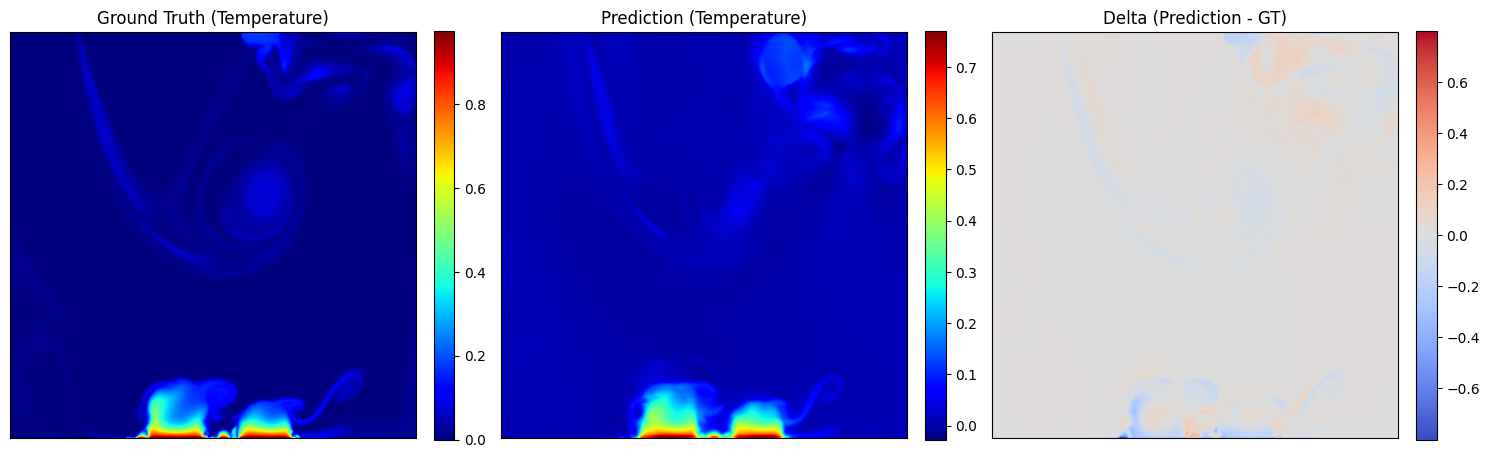

In [ ]:
model = UNet(in_channels=16, c_hidden=16, out_channels=16, depth=3)


model = load_model(model, f"./best_model_haarunet.pth")

error, pred, ground = calculate_error_and_inference_single_step(
    in_b, out_b, model,
    channels=haar_channels,
    reducer=restore_data_3,
    gt_reducer=restore_data,
    mean = mean,
    std = std,
)
print(error)
visualize_frames(ground[0], pred[0], channel_index=0)

## Performance of models on the separate (unseen) dataset (Twall-103)

The Twall-103 dataset is very similar to Twall-100, which was used for training and testing our models. We use Twall-103 for clean validation of both models.

Our testing methodology involves running our models on the entire dataset (200 time steps) and calculating the average RMSE error as a benchmark score.

Given that we are dealing with a complex turbulent flow, it also makes sense to validate how the models perform on specific boiling situations to identify their strengths and weaknesses.

In [ ]:
test_dataset_103 = HaarDataset(data_dir=haar_data_test)
print(test_dataset_103[0][0].shape)
print(len(test_dataset_103))


torch.Size([28, 384, 384])
100


In [ ]:
mean_test, std_test = calculate_channel_mean_std(test_dataset_103)
print(mean_test)
print(std_test)

tensor([ 2.2046e-02,  2.1998e-02, -4.8001e-05,  2.2000e-02, -2.0817e-06,
        -4.7091e-05, -9.1035e-07, -7.0658e-02, -7.0279e-02,  3.7841e-04,
        -7.0235e-02, -4.4227e-05,  3.7678e-04,  1.6278e-06, -1.3777e-02,
        -1.3734e-02,  4.2644e-05, -1.3712e-02, -2.1943e-05,  5.0687e-05,
        -8.0433e-06,  5.9755e+00,  6.0313e+00,  5.5774e-02,  6.0741e+00,
        -4.2812e-02,  4.9856e-02,  5.9173e-03])
tensor([7.7310e-02, 7.3203e-02, 2.4711e-02, 7.1596e-02, 1.5315e-02, 1.5137e-02,
        1.9499e-02, 4.2692e-01, 4.0224e-01, 1.4070e-01, 3.9308e-01, 8.5134e-02,
        8.3113e-02, 1.1326e-01, 5.8341e-01, 5.6571e-01, 1.3750e-01, 5.5793e-01,
        9.2147e-02, 8.8763e-02, 1.0477e-01, 2.8828e+01, 2.0297e+01, 2.0415e+01,
        1.7480e+01, 1.0228e+01, 1.0227e+01, 1.7668e+01])


In [ ]:
transform = Compose([
    Normalise(mean = mean_test[:, None, None],  # Reshape to (C, 1, 1),
              std = std_test[:, None, None]    # Reshape to (C, 1, 1)
    ),
    ToFloat32(),
])

test_dataset = HaarDataset(data_dir=haar_data_test, transform=transform, target_transform=transform)


<ipython-input-58-278adc2d12b6>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean_dev = torch.tensor(mean[channels, None, None]).clone().detach().to(device)
<ipython-input-58-278adc2d12b6>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std_dev = torch.tensor(std[channels, None, None]).clone().detach().to(device)


1.374601


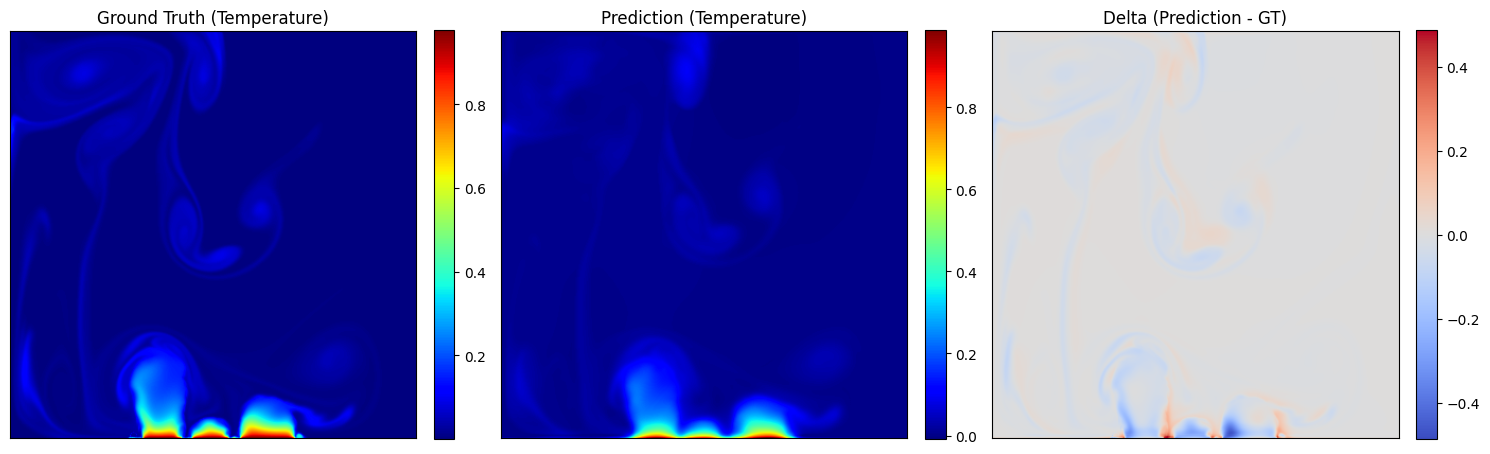

In [ ]:
loader_val = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

model = UNet(in_channels=4, c_hidden=16, out_channels=4, depth=4)


model = load_model(model, f"./best_model_unet-baseline.pth")

error, pred, ground, error_list_base = calculate_error_and_inference(
    loader_val, model,
    channels=base_channels,
    reducer=None,
    gt_reducer=None,
    mean = mean,
    std = std,
)
print(error)
visualize_frames(ground[40], pred[40], channel_index=0)

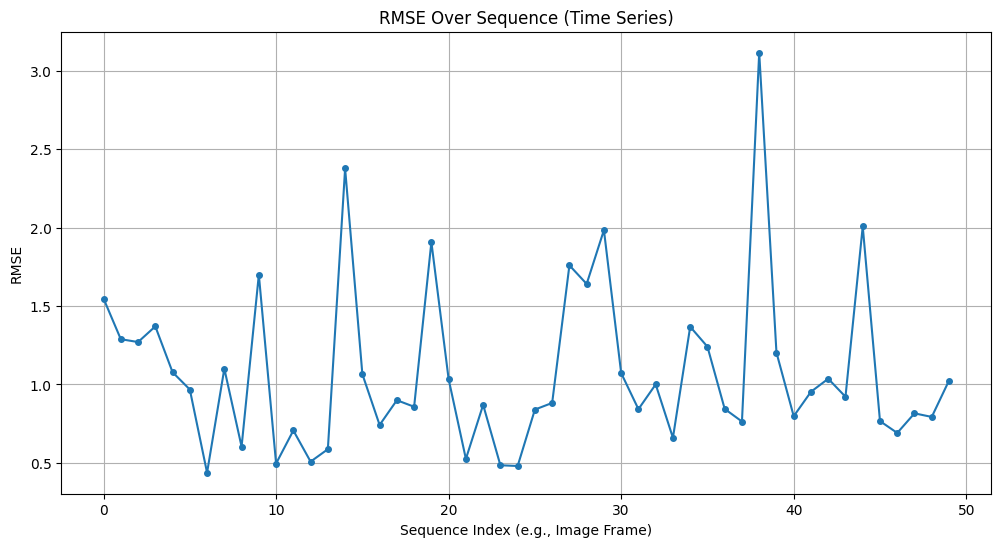

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(error_list_base, marker='o', linestyle='-', markersize=4) # 'o' adds markers, '-' connects them
plt.title('RMSE Over Sequence (Time Series)')
plt.xlabel('Sequence Index (e.g., Image Frame)')
plt.ylabel('RMSE')
plt.grid(True)  # Add grid lines for better readability
plt.show()

<ipython-input-58-278adc2d12b6>:51: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean_dev = torch.tensor(mean[channels, None, None]).clone().detach().to(device)
<ipython-input-58-278adc2d12b6>:52: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std_dev = torch.tensor(std[channels, None, None]).clone().detach().to(device)


1.727737
(1, 4, 384, 384)
(1, 4, 384, 384)


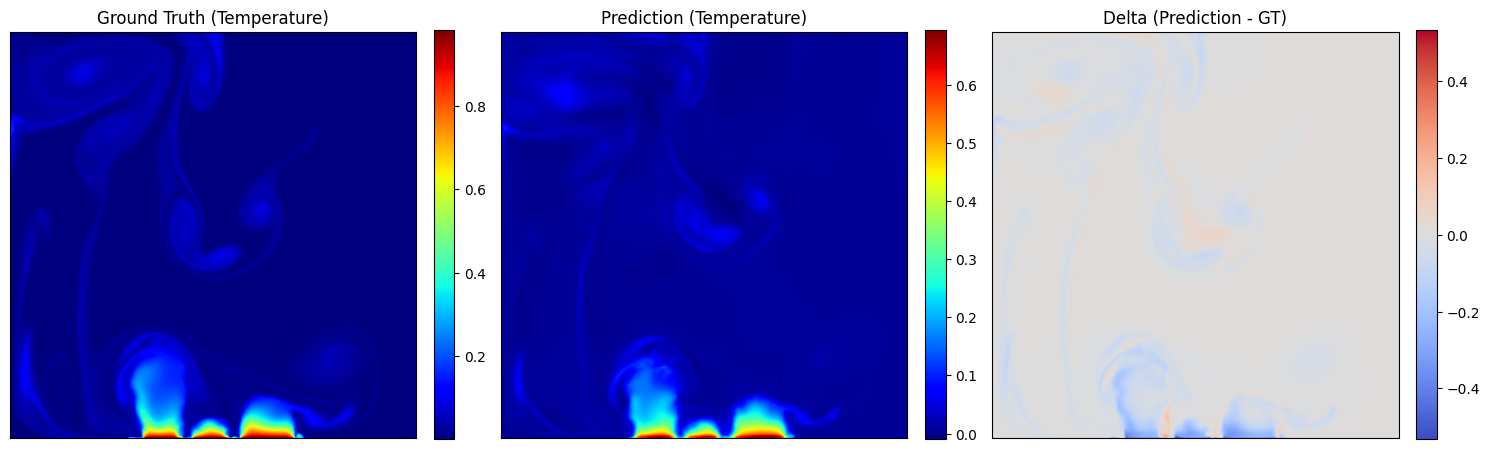

In [ ]:
loader_val = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=2)

model = UNet(in_channels=16, c_hidden=16, out_channels=16, depth=3)


model = load_model(model, f"./best_model_haarunet.pth")

error, pred, ground, error_list = calculate_error_and_inference(
    loader_val, model,
    channels=haar_channels,
    reducer=restore_data_3,
    gt_reducer=restore_data,
    mean = mean,
    std = std,
)
print(error)
print(pred[0].shape)
print(ground[0].shape)
visualize_frames(ground[40], pred[40], channel_index=0)


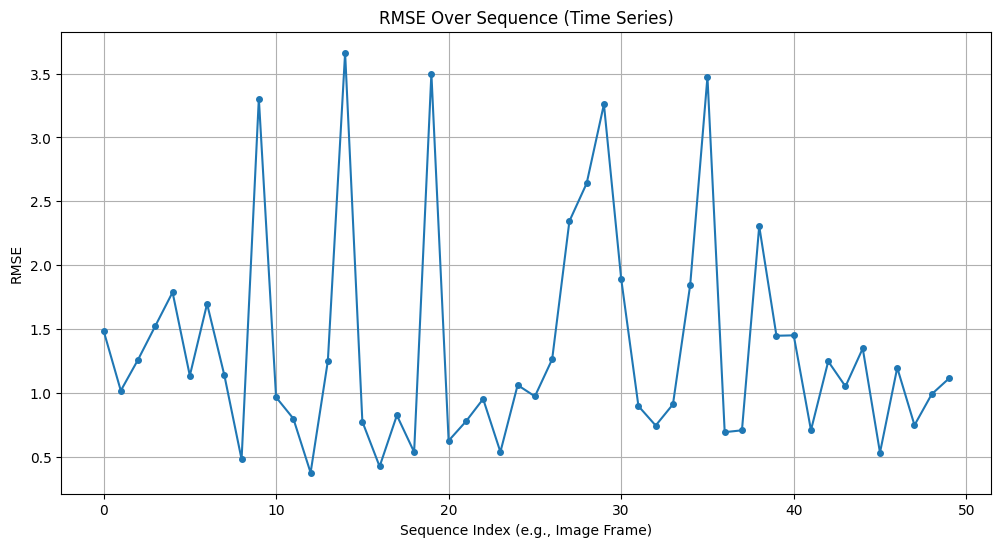

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(error_list, marker='o', linestyle='-', markersize=4) # 'o' adds markers, '-' connects them
plt.title('RMSE Over Sequence (Time Series)')
plt.xlabel('Sequence Index (e.g., Image Frame)')
plt.ylabel('RMSE')
plt.grid(True)  # Add grid lines for better readability
plt.show()

## Error analysis

Since we are dealing with sequencial data (time series), in this section we analysed the distribution of RMSE over sequence. This gives some valuable insights on weak and strong sides of each model.

In [ ]:
def stats(err_li):
  Q1 = np.percentile(err_li, 25)
  Q3 = np.percentile(err_li, 75)
  IQR = Q3 - Q1
  lower_bound = Q1 - 1.5 * IQR
  upper_bound = Q3 + 1.5 * IQR

  print("\n--- Outlier Analysis (IQR Method) ---")
  print(f"Lower Bound: {lower_bound:.4f}")
  print(f"Upper Bound: {upper_bound:.4f}")
  print(f"Mean RMSE: {np.mean(err_li):.4f}")
  print(f"Median RMSE: {np.median(err_li):.4f}")
  print(f"Standard Deviation RMSE: {np.std(err_li):.4f}")

In [ ]:
stats(error_list_base)
stats(error_list)


--- Outlier Analysis (IQR Method) ---
Lower Bound: 0.0162
Upper Bound: 2.0103
Mean RMSE: 1.0782
Median RMSE: 0.9371
Standard Deviation RMSE: 0.5261

--- Outlier Analysis (IQR Method) ---
Lower Bound: -0.3364
Upper Bound: 2.6247
Mean RMSE: 1.3527
Median RMSE: 1.0862
Standard Deviation RMSE: 0.8517


# Observations

We observe a very similar distribution of RMSE, which is not surprising since we are using the same core model (U-Net). However, visual analysis reveals that our approach results in more fine and sharp details in the prediction, even though the average error is at a similar level. Further work will be needed to **formulate the criteria** which can be used to distinguish models which have the properties and traits **important in long shot rollout predictions**.

We also note, that our model is much smaller than the baseline one (2.83 MB vs 11.28 MB). Since we didn't optimize our models, finding the ceiling of accuracy for both models might be an interesting topic to research.

# Conclusions and Further Work

In our work, we have demonstrated a novel technique to improve turbulent quasi-chaotic simulation, contributing to advancements in the broader field of
Scientific Machine Learning (SciML). We note the technique's ability to better capture the high-frequency components of the turbulent spectrum.

Further generalization of this method using more sophisticated decomposition
techniques, such as POD or PCA, holds promising potential.

## Acknowledgements

We want to thank I-X/Imperial College London, and especially [Gege Wen and Shala Khan], for their help to allocate HPC resources for this project.